In [1]:
from pathlib import PurePath, Path
pp = PurePath(Path.cwd()).parts[:-1]
pdir = PurePath(*pp)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from multiprocessing import Pool
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import BallTree

In [2]:
bid, ask = pd.read_csv(str(pdir) + '/data/eurusd-bid-1h.csv'), pd.read_csv(str(pdir) + '/data/eurusd-ask-1h.csv')
mids = ((bid.iloc[:, 1] + ask.iloc[:, 1]) / 2).dropna()

# data = pd.read_csv(str(pdir) + '/data/eurusd_30m.csv')
# mids = ((data.bid_close + data.ask_close)/2).dropna()

In [3]:
# separate training & validation from testing range
data = mids.iloc[: int(0.8 * len(mids))]

time_delays = np.unique(np.logspace(0, 2, num=10, dtype='int'))
dims = np.array(range(2, 10 + 1))

In [4]:
# shortened version of Embedding class
class Embedding:
    def __init__(self, data):
        self.data = data
        
    def embedding(self, tau, m):
        """
        fn: Given time-delay and number of dimension returns embedded data
        :param tau: int, time-delay
        :param m: int, dimension
        :return: md array with embedded data
        """
        points = []

        for i, row in enumerate(self.data.values):
            point = []
            for j in range(m):
                if i + j * tau < len(self.data.values):
                    point.append(self.data.values[i + j * tau])

            if len(point) == m:
                points.append(point)

        return points

In [5]:
# slightly modified Method of Analogues
class PPMD:
    def __init__(self, features, labels, k=5):
        self.features = features
        self._kdtree = BallTree(features)
        self._y = labels
        self._k = k

    def majority(self, label_indices):
        assert len(label_indices) == self._k, "Did not get k inputs"

        # Get the labels of the k nearest neighbors
        knn_labels = []
        for label_index in label_indices:
            knn_labels.append(self._y[label_index])

        # Return the median of the next label
        median_vector = []
        for i in range(len(knn_labels[0])):
            median_vector.append(np.median([row[i] for row in knn_labels]))

        return median_vector

    def classify(self, feature_set):
        # ind = self._kdtree.query_radius(feature_set.reshape(1, -1), r=1)
        dist, ind = self._kdtree.query(feature_set.reshape(1, -1), k=self._k)

        return self.majority(ind[0])

    def error(self, prediction, truth):

        assert len(prediction) == len(truth), "Number of predictions much equal the number of real data points."

        error = np.abs(np.array(prediction) - np.array(truth))
        random_walk = np.abs(np.diff(self.features, axis=0)).sum()

        return np.array(error/((len(prediction)/(len(self.features) - 1.0))*random_walk)).sum()


In [6]:
# function is used for parallel calculation
def parallel_map(func, values, args=tuple(), kwargs=dict(), processes=None):
    if processes == 1:
        return np.asarray([func(value, *args, **kwargs) for value in values])
    
    pool = Pool(processes=processes)
    results = [pool.apply_async(func, (value,) + args, kwargs)
               for value in values]

    pool.close()
    pool.join()

    return np.asarray([result.get() for result in results])

In [8]:
class Optimize:
    def __init__(self, time_delays, dims):
        self.time_delays = time_delays
        self.dims = dims
        self.tscv = TimeSeriesSplit(n_splits=3)
    
    def brute_force(self, x, parallel=True):
        """
        fn: Parallels _brute_force() method over the range of time-delays
        """
        if parallel:
            processes = None
        else:
            processes = 1
        
        results = []
        for tau in self.time_delays:
            parallel_results = parallel_map(self._brute_force, self.dims, (x, ), {'tau': tau}, processes)
            results += np.array(parallel_results).T.tolist()

        return results
    
    def _brute_force(self, d, x, tau=1):
        # create embedded data
        features = []; labels = []
        _embedding = Embedding(x)
        embedded = _embedding.embedding(tau=tau, m=d)
        
        # feature/label generation
        for i, vector in enumerate(embedded):
            if(i + 1) >= len(embedded):
                break
            features.append(vector)
            labels.append(embedded[i + 1])

        features = np.array(features)
        labels = np.array(labels)

        error_train, error_validation = [], []
        sign_train, sign_validation = [], []
        
        for train_index, validation_index in self.tscv.split(features):
            X_train, X_validation = features[train_index], features[validation_index]
            y_train, y_validation = labels[train_index], labels[validation_index]

            ppmd = PPMD(X_train, y_train)

            prediction = []; truth = []; s = 0
            for i in range(len(X_train)):
                pred = ppmd.classify(X_train[i])
                prediction.append(pred)
                truth.append(y_train[i])
                
                if np.sign(np.median(pred) - np.median(X_train[i])) == np.sign(np.median(y_train[i]) - np.median(X_train[i])):
                    s += 1
            
            sign_train.append(s/len(prediction))
            error_train.append(ppmd.error(prediction, truth))

            prediction = []; truth = []; s = 0
            for i in range(len(X_validation)):
                pred = ppmd.classify(X_validation[i])
                prediction.append(pred)
                truth.append(y_validation[i])
                
                if np.sign(np.median(pred) - np.median(X_validation[i])) == np.sign(np.median(y_validation[i]) - np.median(X_validation[i])):
                    s += 1
            
            sign_validation.append(s/len(prediction))
            error_validation.append(ppmd.error(prediction, truth))

        error_train = np.average(np.array(error_train))
        error_validation = np.average(np.array(error_validation))
        sign_train = np.average(np.array(sign_train))
        sign_validation = np.average(np.array(sign_validation))
        
        temp_dict = {'dimension': d,
            'delay': tau,
            'MASE_train': error_train,
            'MASE_validation': error_validation,
            'SIGN_train': sign_train,
            'SIGN_validation': sign_validation}
        
        print('For dimension = {0} and delay = {1} Errors on TRAIN = {2}, VALIDATE = {3}'
              .format(d, tau, error_train, error_validation))
        
        return temp_dict
    
    def save_brute_results(self, results, name):
#        # assert isinstance(results, pd.DataFrame), 'Results should be pd.DataFrame() type'
        results = pd.DataFrame(results)
        results.to_csv(str(pdir) + "/signals/MASE_" + name, index=False)
        return

In [14]:
# iterating through time-delay and dimensions to calculate MASE
_optimize = Optimize(time_delays, dims)

# UNCOMMENT SECTION BELOW TO CALCULATE

# results = _optimize.brute_force(data)
# _optimize.save_brute_results(results, 'eurusd_60m.csv')

In [17]:
# load saved MASE values
error_dataset = pd.read_csv(str(pdir) + "/signals/MASE_eurusd_30m.csv")
delay_range = np.unique(np.array(error_dataset['delay']))
dim_range = np.unique(np.array(error_dataset['dimension']))

print(error_dataset.shape)
error_dataset.head()

(675, 4)


,MASE_train,MASE_validation,delay,dimension
0,0.465348,0.476806,1,2
1,0.377681,0.398621,1,3
2,0.367745,0.396667,1,4
3,0.381018,0.411726,1,5
4,0.402885,0.432242,1,6


Min MASE: 0.4653477627415449 for dim = 2 and delay =1
Min MASE: 0.37768071018272414 for dim = 3 and delay =1
Min MASE: 0.3677450829927231 for dim = 4 and delay =1
Min MASE: 0.3810180520019011 for dim = 5 and delay =1
Min MASE: 0.40288509259268457 for dim = 6 and delay =1
Min MASE: 0.4245533298390956 for dim = 7 and delay =1
Min MASE: 0.4448361432496213 for dim = 8 and delay =1
Min MASE: 0.46530204569866607 for dim = 9 and delay =1
Min MASE: 0.483707346299011 for dim = 10 and delay =1


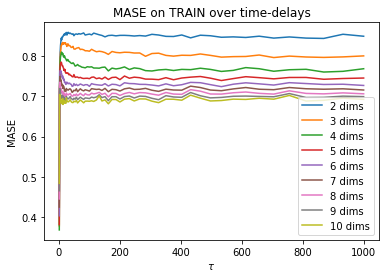

In [18]:
for dim in dim_range:
    yy =  error_dataset.loc[error_dataset['dimension'] == dim]['MASE_train'].values
    print('Min MASE: {0} for dim = {1} and delay ={2}'.format(min(yy), dim,
                                                        delay_range[yy.argmin()]))
    plt.plot(delay_range, yy, label=str(dim) + ' dims')

plt.title('MASE on TRAIN over time-delays')
plt.xlabel(r'$\tau$')
plt.ylabel('MASE')
plt.legend()
plt.show()

Min MASE: 0.4768063639462632 for dim = 2 and delay =1
Min MASE: 0.3986209499809428 for dim = 3 and delay =1
Min MASE: 0.3966672252991545 for dim = 4 and delay =1
Min MASE: 0.4117259646432593 for dim = 5 and delay =1
Min MASE: 0.4322415138421771 for dim = 6 and delay =1
Min MASE: 0.4543856790826244 for dim = 7 and delay =1
Min MASE: 0.4739875810732154 for dim = 8 and delay =1
Min MASE: 0.4908395754300279 for dim = 9 and delay =1
Min MASE: 0.5035477768766509 for dim = 10 and delay =1


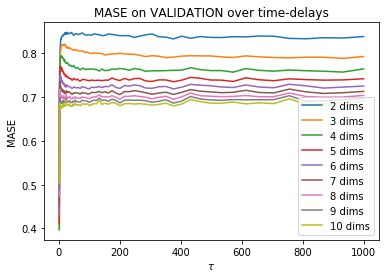

In [19]:
for dim in dim_range:
    yy =  error_dataset.loc[error_dataset['dimension'] == dim]['MASE_validation'].values
    print('Min MASE: {0} for dim = {1} and delay ={2}'.format(min(yy), dim,
                                                        delay_range[yy.argmin()]))
    plt.plot(delay_range, yy, label=str(dim) + ' dims')

plt.title('MASE on VALIDATION over time-delays')
plt.xlabel(r'$\tau$')
plt.ylabel('MASE')
plt.legend()
plt.show()

pandas.core.series.Series